In [2]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests


tickers_list = ['NVDA']

In [ ]:
# 用 BeautifulSoup 浏览本周新闻头条

news = pd.DataFrame()

for ticker in tickers_list:
   url = f'https://finviz.com/quote.ashx?t={ticker}&p=d'
   ret = requests.get(
       url,
       headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'},
   )

   html = BeautifulSoup(ret.content, "html.parser")

   try:
     df = pd.read_html(
         str(html),
         attrs={'class': 'fullview-news-outer'}
     )[0]
   except:
     print(f"{ticker} No news found")
     continue

   df.columns = ['Date', 'Headline']

df.tail()

C:\Users\haozh\AppData\Local\Temp\ipykernel_25920\296017485.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(


,Date,Headline
98,11:00AM,Markets 2024: Breaking down the year's best pe...
99,10:46AM,Vistra Shines Bright: 264% Return Tops S&P 500...
100,10:15AM,"Nvidia, Microsoft Expected to Lead AI Growth i..."
101,10:03AM,Nvidia Stock Has Soared 176% This Year. These ...
102,09:30AM,Missed Out on SoundHound AI's Run-Up? My Best ...


In [4]:
# Process date and time columns to make sure this is filled in every headline each row
dateNTime = df.Date.apply(lambda x: ','+x if len(x)<8 else x).str.split(r' |,', expand = True).replace("", None).ffill()

df = pd.merge(df, dateNTime, right_index=True, left_index=True).drop('Date', axis=1).rename(columns={0:'Date', 1:'Time'})

df = df[df["Headline"].str.contains("Loading.") == False].loc[:, ['Date', 'Time', 'Headline']]

df["Ticker"] = ticker
news = pd.concat([news, df], ignore_index = True)

news.head()

# NVDA 本周新闻头条

,Date,Time,Headline,Ticker
0,Today,06:41PM,Nvidias CES 2025 keynote: How to watch (TechCr...,NVDA
1,Today,06:26PM,Analysts focus on Nvidia ahead of key tech eve...,NVDA
2,Today,06:15PM,"AI infrastructure, compute: Ben Bajarin's 2025...",NVDA
3,Today,05:10PM,How to watch CES 2025s press conferences (Tech...,NVDA
4,Today,04:57PM,"As Hope of Santa Claus Rally Fades, What's Nex...",NVDA


In [5]:
# 使用 vader_lexicon 对 ['Headline'] 应用 SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

scored_news = news.join(
  pd.DataFrame(news['Headline'].apply(vader.polarity_scores).tolist())
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\haozh\AppData\Roaming\nltk_data...


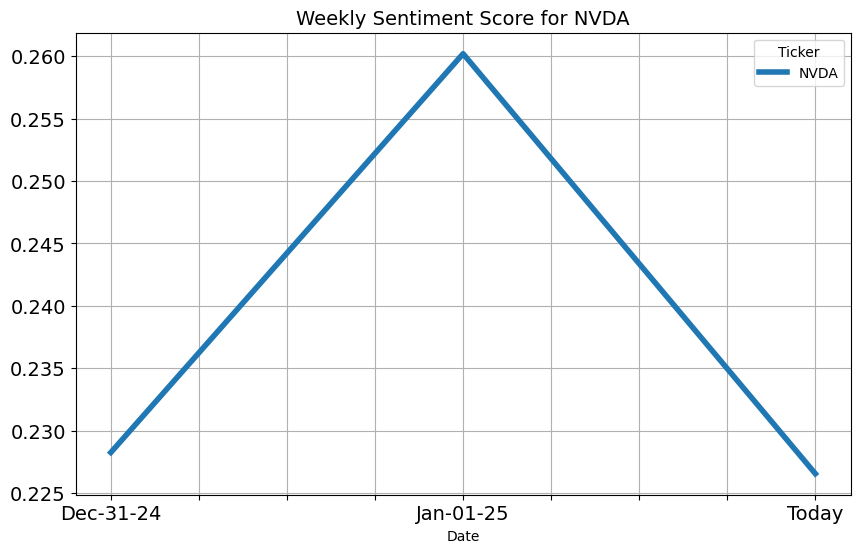

In [6]:
# 绘制 NVDA 的每周情绪得分图

news_score = scored_news.loc[:, ['Ticker', 'Date', 'compound']].pivot_table(values='compound', index='Date', columns='Ticker', aggfunc='mean').ewm(15).mean()
news_score.dropna().plot(figsize=(10, 6),linewidth=4,kind='line',legend=True, fontsize=14)
plt.title("Weekly Sentiment Score for NVDA",fontsize=14)
plt.grid()

In [ ]:
# 接下来我们绘制 NVDA 周情绪得分百分比变化图

news_score.pct_change().dropna().plot(figsize=(10, 6),linewidth=4,kind='line',legend=True, fontsize=14)
plt.title("Percentage Change of Weekly Sentiment Score for NVDA",fontsize=14)
plt.grid()